In [1]:
from __future__ import division
import os
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

# For time stamps
from datetime import datetime

# import models
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import keras
import tensorflow as tf

# get a helper function for splitting the dataset into training and test sets
from sklearn.model_selection import train_test_split
# get a function for measuring test error
from sklearn.metrics import mean_absolute_error
# get a standard scaler for normalization 
from sklearn.preprocessing import StandardScaler

# import keras again for building neural network models
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, MaxPooling1D, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [2]:
isdownload = True

stocknames = ['0002.HK', '0003.HK', '0012.HK', '0017.HK', '1398.HK', '3988.HK', '0669.HK', '2382.HK', '1299.HK', '0388.HK']
startdate = '2011-01-01'
enddate = '2017-12-31'
window = 20
target = 5
valid_len = 250

if isdownload == False:
    for stock in stocknames:
        df = yf.download(stock, startdate, enddate)
        df.to_csv('data/{}.csv'.format(stock))

In [3]:
def appending(cols=[], startdate='', enddate=''):
    global df
    dates = pd.date_range(start=startdate, end=enddate)
    df = pd.DataFrame(index=dates)
    for stock in stocknames:
        df_symbols = pd.read_csv(os.path.join('data/{}.csv'.format(stock)),
                                index_col='Date', parse_dates=True, usecols=cols, na_values=['NaN'])
        df_symbols = df_symbols.rename(columns={'Close': stock})
        df = df.join(df_symbols)
        df = df.loc[dates]
    df = df.dropna()
    return df

In [4]:
def preprocess_data(df,window):
    # Rename the first column of the DataFrame to 'close'
    df.rename(columns={df.columns[0]: 'close'}, inplace=True)

    for n in range(1, window+1):
        df[f'{n}_day_chg%'] = df.close.pct_change(n) * 100

    # Calculate the next week's percentage change and add it as a new column
    df['nextWeekChg%'] = (1 / (1 + df['close'].pct_change(-target)) - 1) * 100

    # Drop rows with missing values
    df = df.dropna()

    # Initialize MinMaxScaler for X and Y
    Xscaler, Yscaler = MinMaxScaler(feature_range = (0, 1)),MinMaxScaler(feature_range = (0, 1))

    # Select X and Y columns from the DataFrame
    X = df[list(filter(lambda x: "day_chg%" in x, df.columns))]
    Y = df[["nextWeekChg%"]]

    # Scale X and Y using MinMaxScaler
    X, Y = Xscaler.fit_transform(X), Yscaler.fit_transform(Y)

    # Split the data into x_train and y_train
    x_train, y_train = np.array(X[:-valid_len]), np.array(Y[:-valid_len])

    # Split the data into x_train and y_train
    x_test, y_test = np.array(X[-valid_len:]), np.array(Y[-valid_len:])

    # Reshape x_train and  to match the expected input shape for the model
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return Xscaler, Yscaler, X, Y, x_train, y_train, x_test, y_test

In [5]:
dfs =appending(['Date', 'Close'], startdate, enddate)
dfs.index.names = ['Date']
dfs.to_csv("data/overall.csv")

In [6]:
# Example usage
df = pd.DataFrame(dfs[stocknames[9]])
# Preprocess the data
Xscaler, Yscaler, X, Y, x_train, y_train , x_test, y_test= preprocess_data(df,window)
# Print the shapes and types of x_train and y_train
print("x_train:", x_train.shape, ", y_train:", y_train.shape)
print("x_train:", type(x_train), ", y_train:", type(y_train))

x_train: (1450, 20, 1) , y_train: (1450, 1)
x_train: <class 'numpy.ndarray'> , y_train: <class 'numpy.ndarray'>


Epoch 1/15
145/145 [==============================] - 3s 5ms/step - loss: 0.1039 - mae: 0.3158 - mse: 0.1039 - mean_absolute_percentage_error: 1652.6978
Epoch 2/15
145/145 [==============================] - 1s 5ms/step - loss: 0.0795 - mae: 0.2741 - mse: 0.0795 - mean_absolute_percentage_error: 51172.3867
Epoch 3/15
145/145 [==============================] - 1s 5ms/step - loss: 0.0568 - mae: 0.2277 - mse: 0.0568 - mean_absolute_percentage_error: 74757.9609
Epoch 4/15
145/145 [==============================] - 1s 5ms/step - loss: 0.0369 - mae: 0.1769 - mse: 0.0369 - mean_absolute_percentage_error: 95871.8203
Epoch 5/15
145/145 [==============================] - 1s 5ms/step - loss: 0.0216 - mae: 0.1236 - mse: 0.0216 - mean_absolute_percentage_error: 159994.5000
Epoch 6/15
145/145 [==============================] - 1s 5ms/step - loss: 0.0135 - mae: 0.0885 - mse: 0.0135 - mean_absolute_percentage_error: 151932.5469
Epoch 7/15
145/145 [==============================] - 1s 5ms/step - loss: 0

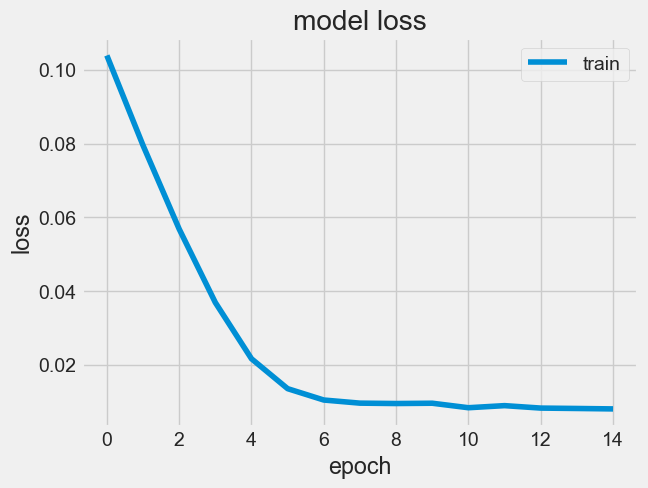

In [7]:
DropoutRate = 0.2
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(DropoutRate))
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(DropoutRate))
model.add(LSTM(units=16, return_sequences=False))
model.add(Dropout(DropoutRate))
model.add(Dense(8))
model.add(Dense(units=1))
# Compile the model
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=["mae", "mse", tf.keras.metrics.MeanAbsolutePercentageError()])

# Train the model
history = model.fit(x_train, y_train, batch_size=10, epochs=15)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [8]:

print("x_test:", x_test.shape, ", y_test:", y_test.shape)
print("x_test:", type(x_test), ", y_test:", type(y_test))


x_test: (250, 20, 1) , y_test: (250, 1)
x_test: <class 'numpy.ndarray'> , y_test: <class 'numpy.ndarray'>


In [9]:
predictions = model.predict(x_test)
predictions = Yscaler.inverse_transform(predictions)
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

8/8 [==============================] - 1s 2ms/step


1.6227398818728929

C:\Users\bruce\AppData\Local\Temp\ipykernel_19680\454600633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.loc[:, "predictChg"] = predictions
C:\Users\bruce\AppData\Local\Temp\ipykernel_19680\454600633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.loc[:, "PredClose"] = valid["close"] * (1 + valid["predictChg"] / 100)


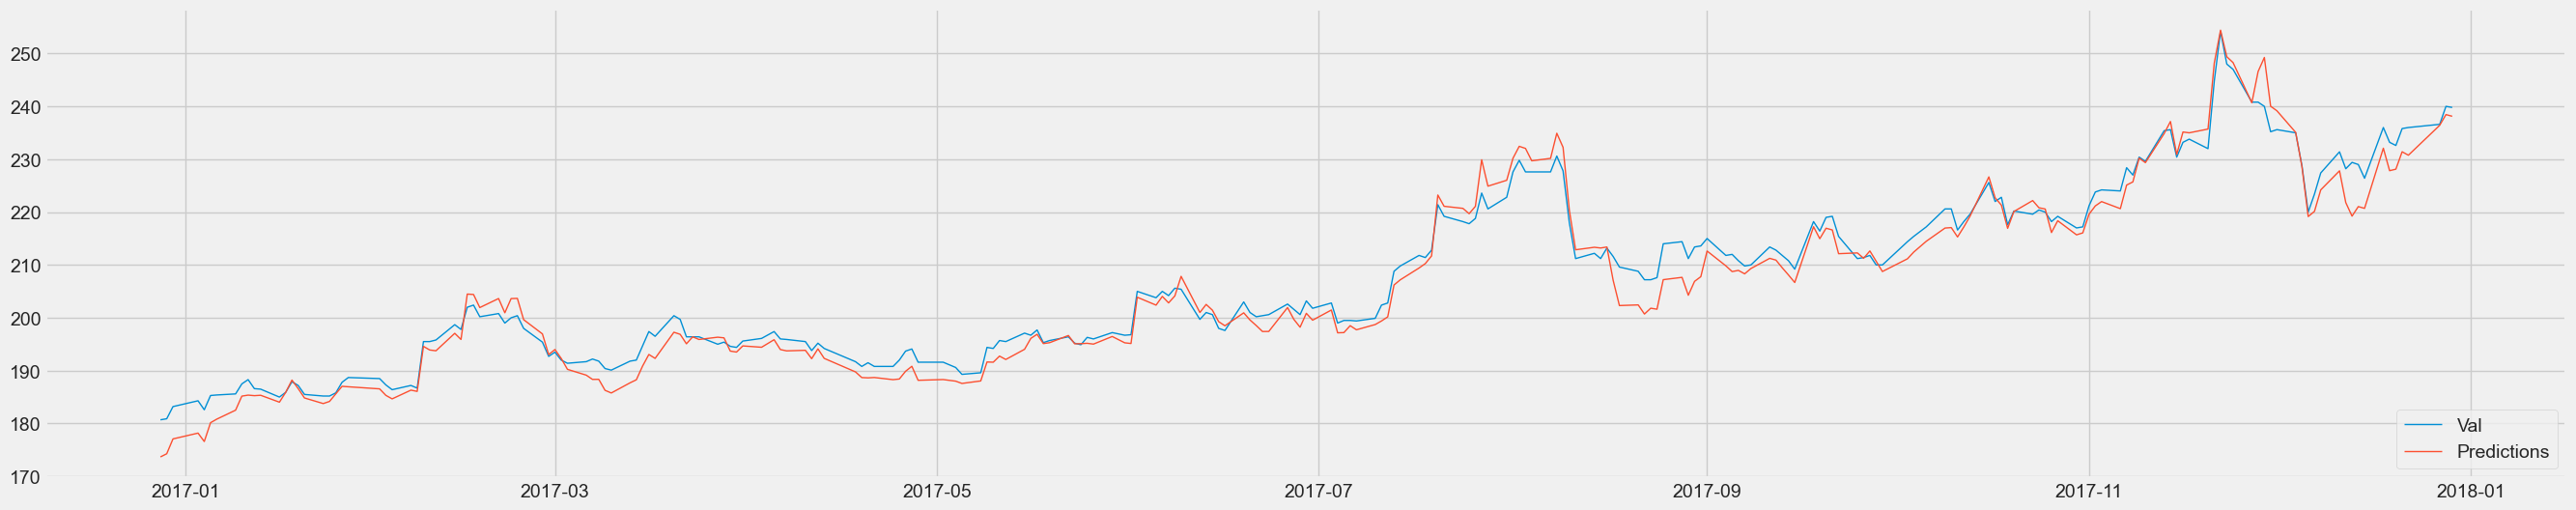

In [10]:
valid = df[-valid_len:]
valid.loc[:, "predictChg"] = predictions
valid.loc[:, "PredClose"] = valid["close"] * (1 + valid["predictChg"] / 100)

plt.figure(figsize=(30, 6))
plt.plot(valid[['close', 'PredClose']], linewidth=1)
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [11]:
trading_df = valid[['close', 'predictChg']]
trading_df['cumulativeChg'] = trading_df['predictChg'].rolling(target).sum()

# trading_df.drop("predictChg", axis=1, inplace=True)
trading_df.dropna(inplace=True)
# predictChg_columns = trading_df.columns[trading_df.columns.str.startswith('predictChg')]
# trading_df['label'] = trading_df[predictChg_columns].sum(axis=1, skipna=True)
stackTrader = trading_df[['close', 'cumulativeChg']].resample('w').last()
stackTrader.head(15)

C:\Users\bruce\AppData\Local\Temp\ipykernel_19680\3831562594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_df['cumulativeChg'] = trading_df['predictChg'].rolling(target).sum()
C:\Users\bruce\AppData\Local\Temp\ipykernel_19680\3831562594.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_df.dropna(inplace=True)


,close,cumulativeChg
Date,,
2017-01-08,185.399994,-15.186884
2017-01-15,186.500000,-5.780745
2017-01-22,185.500000,-1.036069
2017-01-29,188.699997,-2.759984
2017-02-05,186.399994,-4.350837
2017-02-12,195.800003,-3.124555
2017-02-19,200.199997,1.308638
2017-02-26,198.000000,6.678365
2017-03-05,191.399994,0.790910


In [12]:
import pandas as pd

df_filtered = df.loc['2016-01-01':'2016-12-31']
column_data = df_filtered['close'].pct_change().dropna()*100

min_value = column_data.min()
max_value = column_data.max()
mid = np.median(column_data)
mean = np.mean(column_data)
std = np.std(column_data)

print("median:", mid)
print("Mean:", mean)
print("Standard Deviation:", std)
print("Minimum value:", min_value)
print("Maximum value:", max_value)

median: 0.0
Mean: -0.01061191766597933
Standard Deviation: 1.4250223591421793
Minimum value: -5.081874471952008
Maximum value: 5.580858458052518


In [13]:
import pandas as pd

# Reset variables for each iteration
stocks_on_hand = 0
portfolio_value = 0

buy =mean-std
sell = max_value*0.8

# Create a new column to store the action
stackTrader['action'] = ''

for index, row in stackTrader.iterrows():
    price = row['close']
    if row['cumulativeChg'] >= buy and stocks_on_hand == 0:
        stocks_on_hand += 1
        portfolio_value -= price
        stackTrader.at[index, 'action'] = 'buy'
     
    elif not row['cumulativeChg'] < sell and stocks_on_hand == 1:
        stocks_on_hand -= 1
        portfolio_value += price
        stackTrader.at[index, 'action'] = 'sell'
    else:
        stackTrader.at[index, 'action'] = 'hold'
    stackTrader.at[index, 'portfolio'] = portfolio_value + price * stocks_on_hand

# Calculate profit for the current buy and sell levels
profit = portfolio_value + price * stocks_on_hand

print("Maximum Profit:", profit)

Maximum Profit: 50.90000915527338


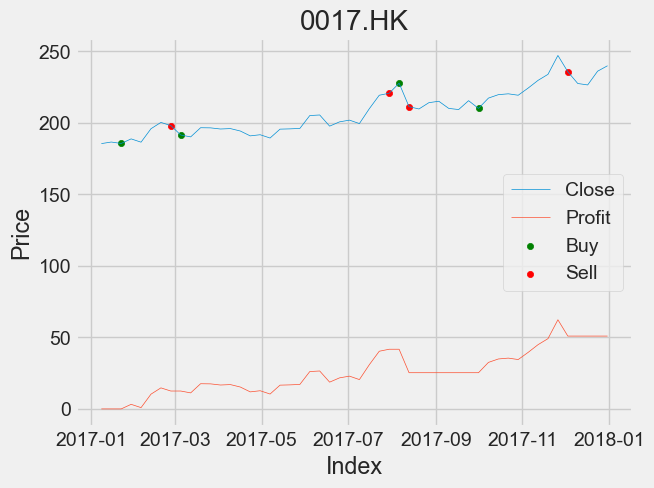

In [14]:
import matplotlib.pyplot as plt

# Plot 'close' prices with a thinner line
plt.plot(stackTrader['close'], label='Close', linewidth=0.5)

# Plot 'profit' with a thinner line
plt.plot(stackTrader['portfolio'], label='Profit', linewidth=0.5)

# Plot 'action' with larger scatter points
buy_indices = stackTrader[stackTrader['action'] == 'buy'].index
sell_indices = stackTrader[stackTrader['action'] == 'sell'].index

plt.scatter(buy_indices, stackTrader.loc[buy_indices, 'close'], color='green', label='Buy', s=20)
plt.scatter(sell_indices, stackTrader.loc[sell_indices, 'close'], color='red', label='Sell', s=20)

# Add legend and labels
plt.legend()
plt.title(stocknames[3])
plt.xlabel('Index')
plt.ylabel('Price')

# Show the plot
plt.show()